In [1]:
import os
import time
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from collections import Counter
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

/Users/patsnap/anaconda2/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
device = torch.device('cpu')
device

device(type='cpu')

In [3]:
datafile = '/Users/patsnap/Desktop/Neo4J_and_other_codes/1014-4361-bundle-archive/ner_dataset.csv'

In [4]:
df = pd.read_csv(datafile, encoding="latin1", error_bad_lines=False)
df = df.fillna(method='ffill')

In [5]:
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [6]:
len(df)

1048575

In [7]:
tags = list(df.Tag.unique())
tags

['O',
 'B-geo',
 'B-gpe',
 'B-per',
 'I-geo',
 'B-org',
 'I-org',
 'B-tim',
 'B-art',
 'I-art',
 'I-per',
 'I-gpe',
 'I-tim',
 'B-nat',
 'B-eve',
 'I-eve',
 'I-nat']

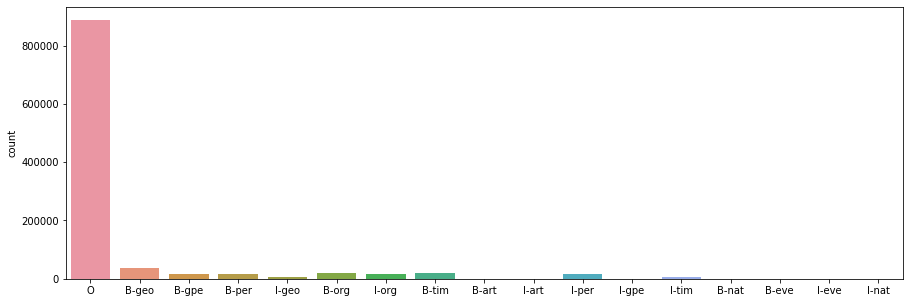

In [8]:
plt.figure(figsize=(15, 5))
sns.countplot(df.Tag.values)

In [9]:
num_tags = len(tags)
num_tags

17

In [23]:
tag2idx = {tag: idx for idx, tag in enumerate(tags)}
idx2tag = {idx: tag for idx, tag in enumerate(tags)}
tag2idx

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-per': 3,
 'I-geo': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'B-art': 8,
 'I-art': 9,
 'I-per': 10,
 'I-gpe': 11,
 'I-tim': 12,
 'B-nat': 13,
 'B-eve': 14,
 'I-eve': 15,
 'I-nat': 16}

In [24]:
agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(), s["POS"].values.tolist(), s["Tag"].values.tolist())]
group = df.groupby("Sentence #").apply(agg_func)
sentences = [s for s in group]

In [25]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [26]:
len(sentences)

47959

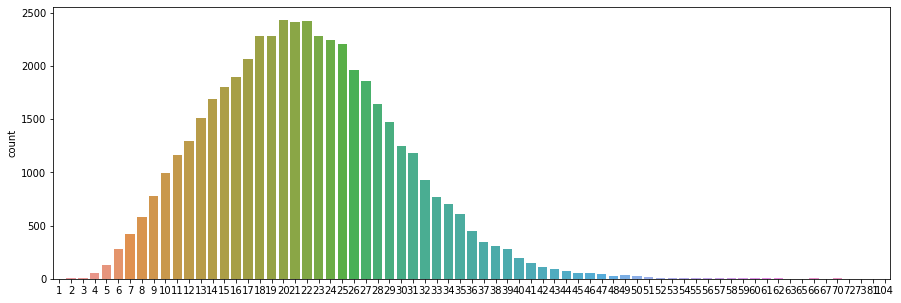

In [27]:
sen_lengths = [len(sent) for sent in sentences]
plt.figure(figsize=(15, 5))
sns.countplot(sen_lengths)

In [28]:
train_data, valid_data = train_test_split(sentences, test_size=0.2, random_state=42)
valid_data, test_data = train_test_split(valid_data, test_size=0.5, random_state=42)
len(train_data), len(valid_data), len(test_data)

(38367, 4796, 4796)

In [29]:
class Vocabulary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [30]:
def build_vocab(sentences, threshold=5):
    """Build a simple vocabulary wrapper."""
    counter = Counter()
    for i, sent in enumerate(sentences):
        tokens = []
        for word, _, _ in sent:
            tokens.append(word)
        counter.update(tokens)

        if (i+1) % 10000 == 0:
            print("[{}/{}] Processed.".format(i+1, len(sentences)))

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

In [31]:
words_vocab = build_vocab(train_data)

[10000/38367] Processed.
[20000/38367] Processed.
[30000/38367] Processed.


In [32]:
MAX_SEN_LEN = 50

In [33]:
class NERDataset(data.Dataset):
    def __init__(self, sentences, max_len):
        self.sentences = sentences
        self.max_len = max_len
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, item):
        sentence = self.sentences[item]
        tokens, tags = [], []

        for word, _, tag in sentence:
            tokens.append(words_vocab(word))
            tags.append(tag2idx[tag])

        return torch.LongTensor(tokens), torch.LongTensor(tags)

In [34]:
train_dataset = NERDataset(train_data, MAX_SEN_LEN)
valid_dataset = NERDataset(valid_data, MAX_SEN_LEN)
test_dataset = NERDataset(test_data, MAX_SEN_LEN)

In [35]:
train_dataset[0]

(tensor([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  3,  3, 15, 16, 17, 18, 19,
          3, 20, 21, 22]),
 tensor([1, 4, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [36]:
BATCH_SIZE = 128

In [37]:
def collate_fn(data):
    data.sort(key=lambda x: len(x[0]), reverse=True)
    sentences, tags = zip(*data)

    # Merge questions (from tuple of 1D tensor to 2D tensor).
    sent_lengths = [len(sent) for sent in sentences]
    inputs = torch.zeros(len(sentences), max(sent_lengths)).long()
    labels = torch.zeros(len(sentences), max(sent_lengths)).long()
    
    for i, (sent, lab) in enumerate(zip(sentences, tags)):
        end = sent_lengths[i]
        inputs[i, :end] = sent[:end]
        labels[i, :end] = lab[:end]

    return inputs, labels, sent_lengths

In [38]:
train_data_loader = data.DataLoader(train_dataset, BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_data_loader = data.DataLoader(valid_dataset, BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_data_loader = data.DataLoader(test_dataset, BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [39]:
sample = next(iter(train_data_loader))

In [40]:
sample[0].shape, sample[1].shape, len(sample[2])

(torch.Size([128, 44]), torch.Size([128, 44]), 128)

In [41]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, tag_vocab_size, dropout=0.3):
        super().__init__()
        self.hid_dim = hid_dim

        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            emb_dim,
            hid_dim,
            bidirectional=True,
            batch_first=True
        )
        self.out = nn.Linear(hid_dim * 2, tag_vocab_size)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, sentences, lengths):
        # sentences => [batch_size, seq_len]
        # lengths => [batch_size]

        embed = self.embedding(sentences)
        embed = self.dropout(embed)
        # embed => [batch_size, seq_len, emb_dim]

        packed_inp = nn.utils.rnn.pack_padded_sequence(embed, lengths, batch_first=True)
        packed_output, _ = self.lstm(packed_inp)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        # outputs => [batch_size, seq_len, hid_dim * 2]

        combined = torch.cat((outputs[:, :, :self.hid_dim], outputs[:, :, self.hid_dim:]), dim=-1)
        combined = self.dropout(combined)
        # combined => [batch_size, seq_len, hid_dim * 2]

        logits = self.out(combined)
        # logits => [batch_size, seq_len, tag_size]

        return logits

In [42]:
vocab_size = len(words_vocab)
emb_dim = 50
hid_dim = 100
tag_vocab_size = num_tags
model = BiLSTM(vocab_size, emb_dim, hid_dim, tag_vocab_size)
model.to(device)

BiLSTM(
  (embedding): Embedding(9620, 50, padding_idx=0)
  (lstm): LSTM(50, 100, batch_first=True, bidirectional=True)
  (out): Linear(in_features=200, out_features=17, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [43]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 606,017 trainable parameters


In [44]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss().to(device)

In [45]:
def categorical_accuracy(preds, y, tag_pad_idx=None):
    max_preds = preds.argmax(dim = 1, keepdim = True)
    max_preds = max_preds.squeeze(1)
    correct = max_preds.eq(y)
    accuracy = correct.sum().item() / (preds.shape[0] * 1.0)
    return accuracy

In [46]:
def train(model, iterator, criterion, optimizer, tag_pad_idx, clip):
    model.train()

    epoch_loss = 0
    epoch_acc = 0

    for batch in iterator:
        sentences = batch[0].to(device)
        tags = batch[1].to(device)
        seq_lengths = batch[2]
        # sentences => [batch_size, seq_len]
        # tags => [batch_size, seq_len]

        optimizer.zero_grad()

        logits = model(sentences, seq_lengths)
        # logits => [batch_size, seq_len, tag_vocab_size]

        packed_logits = nn.utils.rnn.pack_padded_sequence(logits, seq_lengths, batch_first=True)[0]
        packed_tags = nn.utils.rnn.pack_padded_sequence(tags, seq_lengths, batch_first=True)[0]
        loss = criterion(packed_logits, packed_tags)

        acc = categorical_accuracy(packed_logits, packed_tags)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [47]:
def evaluate(model, iterator, criterion, trg_pad_idx):
    model.eval()

    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for batch in iterator:
            sentences = batch[0].to(device)
            tags = batch[1].to(device)
            seq_lengths = batch[2]
            # sentences => [batch_size, seq_len]
            # tags => [batch_size, seq_len]

            optimizer.zero_grad()

            logits = model(sentences, seq_lengths)
            # logits => [batch_size, seq_len, tag_vocab_size]
            
            packed_logits = nn.utils.rnn.pack_padded_sequence(logits, seq_lengths, batch_first=True)[0]
            packed_tags = nn.utils.rnn.pack_padded_sequence(tags, seq_lengths, batch_first=True)[0]
            loss = criterion(packed_logits, packed_tags)
            
            acc = categorical_accuracy(packed_logits, packed_tags)
            epoch_loss += loss.item()
            epoch_acc += acc
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [48]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [49]:
N_EPOCHS = 10
CLIP = 2
best_valid_loss = float('inf')
TAG_PAD_IDX = 0

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_data_loader, criterion, optimizer, TAG_PAD_IDX, CLIP)
    valid_loss, val_acc = evaluate(model, valid_data_loader, criterion, TAG_PAD_IDX)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f} | Val. Loss: {valid_loss:.3f} | Val Acc: {val_acc * 100:.2f}')

Epoch: 01 | Epoch Time: 1m 28s
	Train Loss: 0.328 | Train Acc: 91.71 | Val. Loss: 0.139 | Val Acc: 95.88
Epoch: 02 | Epoch Time: 1m 29s
	Train Loss: 0.146 | Train Acc: 95.64 | Val. Loss: 0.118 | Val Acc: 96.33
Epoch: 03 | Epoch Time: 1m 32s
	Train Loss: 0.125 | Train Acc: 96.20 | Val. Loss: 0.111 | Val Acc: 96.55
Epoch: 04 | Epoch Time: 1m 31s
	Train Loss: 0.115 | Train Acc: 96.46 | Val. Loss: 0.108 | Val Acc: 96.62
Epoch: 05 | Epoch Time: 1m 31s
	Train Loss: 0.108 | Train Acc: 96.60 | Val. Loss: 0.107 | Val Acc: 96.70
Epoch: 06 | Epoch Time: 1m 20s
	Train Loss: 0.103 | Train Acc: 96.71 | Val. Loss: 0.105 | Val Acc: 96.75
Epoch: 07 | Epoch Time: 1m 20s
	Train Loss: 0.100 | Train Acc: 96.82 | Val. Loss: 0.107 | Val Acc: 96.68
Epoch: 08 | Epoch Time: 1m 20s
	Train Loss: 0.097 | Train Acc: 96.88 | Val. Loss: 0.106 | Val Acc: 96.76
Epoch: 09 | Epoch Time: 1m 20s
	Train Loss: 0.094 | Train Acc: 96.96 | Val. Loss: 0.105 | Val Acc: 96.78
Epoch: 10 | Epoch Time: 1m 20s
	Train Loss: 0.092 | Tra

In [50]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [51]:
test_loss, test_acc = evaluate(model, test_data_loader, criterion, TAG_PAD_IDX)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}')

Test Loss: 0.107 | Test Acc: 96.74
